# Grupo de Visão Computacional - Introdução a CNN

> Para essa apresentação adotamos um problema classico na visão computacional que é classificação (multilabel) de dígitos utilizando o dataset MNIST.

>  O MNIST é o conjunto de dados "hello world" da visão computacional. Lançado em 1999, este conjunto de dados clássico de imagens (números manuscritas) serviu e serve de base para algoritmos de classificação e benchmarking de modelos. Mesmo com o surgimento de novas técnicas de aprendizagem de máquina, o MNIST continua a ser um recurso fiável tanto para investigadores como para estudantes.

## Sobre o dataset

> O MNIST contém 70.000 imagens em tons de cinza de dígitos manuscritos (de 0 a 9), divididas em 60.000 exemplos de treinamento e 10.000 exemplos de teste (que pode ser alterado).

> Cada imagem tem 28 pixels de altura e 28 pixels de largura, totalizando 784 (28x28) pixels.

> As imagens já estão em apenas um canal, ou seja, cada pixel tem um único valor de pixel associado a ele, indicando a claridade ou escuridão desse pixel, com números mais altos significando mais escuro. Este valor de pixel é um número inteiro entre 0 e 255.

>

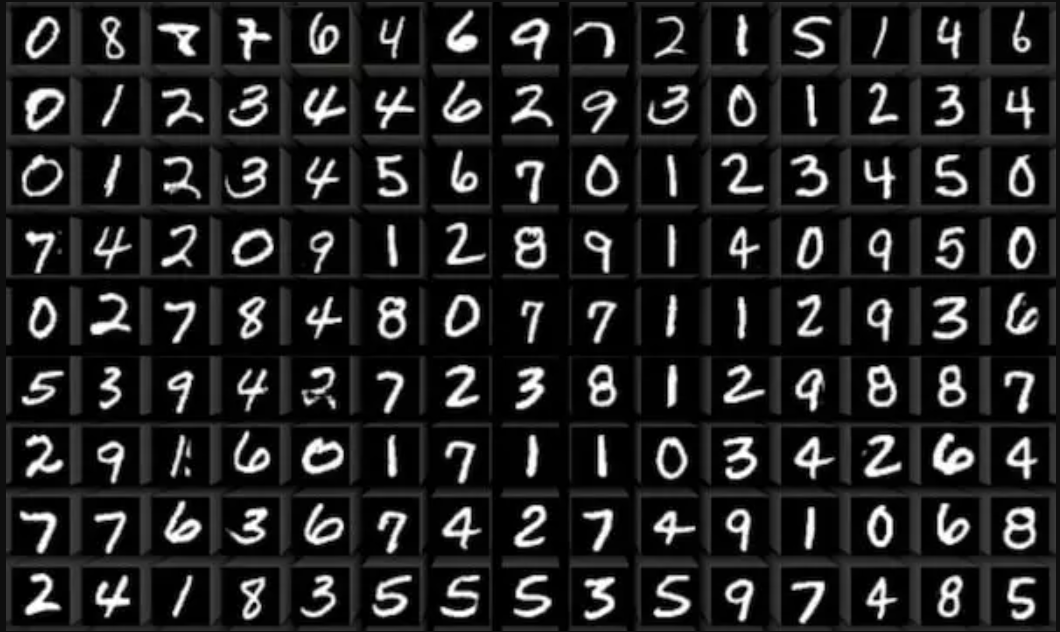

> O objetivo então é conseguir classificar corretamente um número manuscrito!

## Importação das bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.python import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
import seaborn as sns
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files

## Dataset

In [ ]:
# Carregar dados do MNIST
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Visualizar os formatos dos dados
print(f"Formato de x_train: {X_train.shape}, y_train: {Y_train.shape}")
print(f"Formato de x_test: {X_test.shape}, y_test: {Y_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Formato de x_train: (60000, 28, 28), y_train: (60000,)
Formato de x_test: (10000, 28, 28), y_test: (10000,)


In [ ]:
# Redimensionar as imagens para adicionar a dimensão do canal (necessário para CNNs) - Indicar que so tem um canal
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# Normalizar os valores para o intervalo [0, 1]
X_train /= 255.0
X_test /= 255.0

print(f"Novos formatos: x_train: {X_train.shape}, x_test: {X_test.shape}")

Novos formatos: x_train: (60000, 28, 28, 1), x_test: (10000, 28, 28, 1)


In [ ]:
# Converter os rótulos para one-hot encoding
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)

print(f"Exemplo de rótulos (one-hot encoded):\n{Y_train[:5]}")

Exemplo de rótulos (one-hot encoded):
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [ ]:
# Verificar se há dados ausentes
print("Valores ausentes em x_train:", np.isnan(X_train).sum())
print("Valores ausentes em x_test:", np.isnan(X_test).sum())
print("Valores ausentes em y_train:", np.isnan(Y_train).sum())
print("Valores ausentes em y_test:", np.isnan(Y_test).sum())

Valores ausentes em x_train: 0
Valores ausentes em x_test: 0
Valores ausentes em y_train: 0
Valores ausentes em y_test: 0


### Distribuição de classes

<ipython-input-6-d6144a440785>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_distribution.index, y=train_distribution.values, palette="viridis")


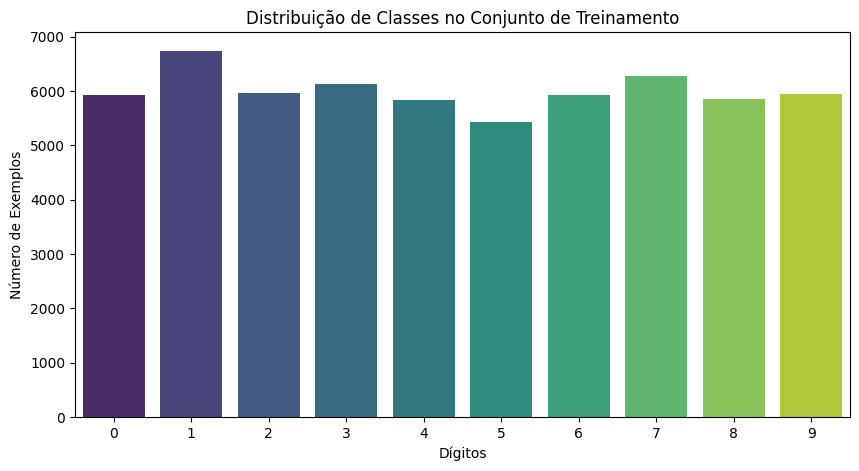

In [ ]:
# Contar as classes no conjunto de TRAIN
class_counts_train = np.argmax(Y_train, axis=1)  # Converte one-hot encoding para rótulos
train_distribution = pd.Series(class_counts_train).value_counts().sort_index()

# Plotar a distribuição
plt.figure(figsize=(10, 5))
sns.barplot(x=train_distribution.index, y=train_distribution.values, palette="viridis")
plt.title("Distribuição de Classes no Conjunto de Treinamento")
plt.xlabel("Dígitos")
plt.ylabel("Número de Exemplos")
plt.show()

<ipython-input-7-7d4ecaab2a9f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_distribution.index, y=test_distribution.values, palette="mako")


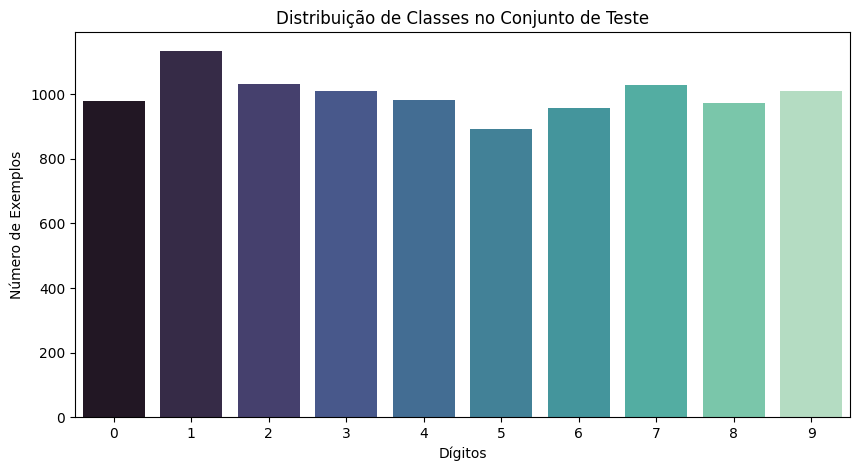

In [ ]:
# Contar as classes no conjunto de TEST
class_counts_test = np.argmax(Y_test, axis=1)  # Converte one-hot encoding para rótulos
test_distribution = pd.Series(class_counts_test).value_counts().sort_index()

# Plotar a distribuição
plt.figure(figsize=(10, 5))
sns.barplot(x=test_distribution.index, y=test_distribution.values, palette="mako")
plt.title("Distribuição de Classes no Conjunto de Teste")
plt.xlabel("Dígitos")
plt.ylabel("Número de Exemplos")
plt.show()

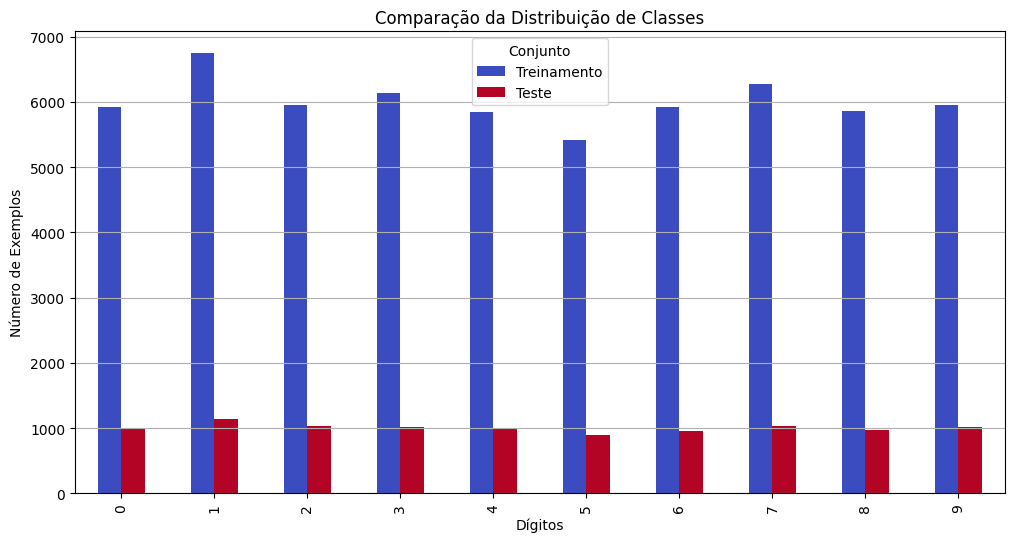

In [ ]:
# Combinar as distribuições em um único dataframe
distribution_df = pd.DataFrame({
    "Treinamento": train_distribution,
    "Teste": test_distribution
})

# Plotar lado a lado
distribution_df.plot(kind="bar", figsize=(12, 6), colormap="coolwarm")
plt.title("Comparação da Distribuição de Classes")
plt.xlabel("Dígitos")
plt.ylabel("Número de Exemplos")
plt.legend(title="Conjunto")
plt.grid(axis="y")
plt.show()

### Visualização

In [ ]:
# Função para coletar amostras de imagens com base nas classes
def sample_images_data(x_data, y_data, num_samples=4, img_rows=28, img_cols=28):
    sample_images = []
    sample_labels = []

    # Coletar 'num_samples' de cada classe
    for label in range(10):  # Classes de 0 a 9
        # Identificar índices das imagens com a classe atual
        indices = np.where(np.argmax(y_data, axis=1) == label)[0][:num_samples]
        for idx in indices:
            img = x_data[idx].reshape(img_rows, img_cols)
            sample_images.append(img)
            sample_labels.append(label)

    print(f"Total de imagens coletadas: {len(sample_images)}")
    return sample_images, sample_labels

In [ ]:
# Função para exibir as imagens coletadas em grid
def plot_sample_images(data_sample_images, data_sample_labels, cmap="Greens"):
    # Configurar a grade para plotar as imagens
    f, ax = plt.subplots(5, 8, figsize=(16, 10))
    f.tight_layout()

    for i, img in enumerate(data_sample_images):
        ax[i // 8, i % 8].imshow(img, cmap=cmap)
        ax[i // 8, i % 8].axis('off')
        ax[i // 8, i % 8].set_title(data_sample_labels[i])
    plt.show()

Total de imagens coletadas: 40


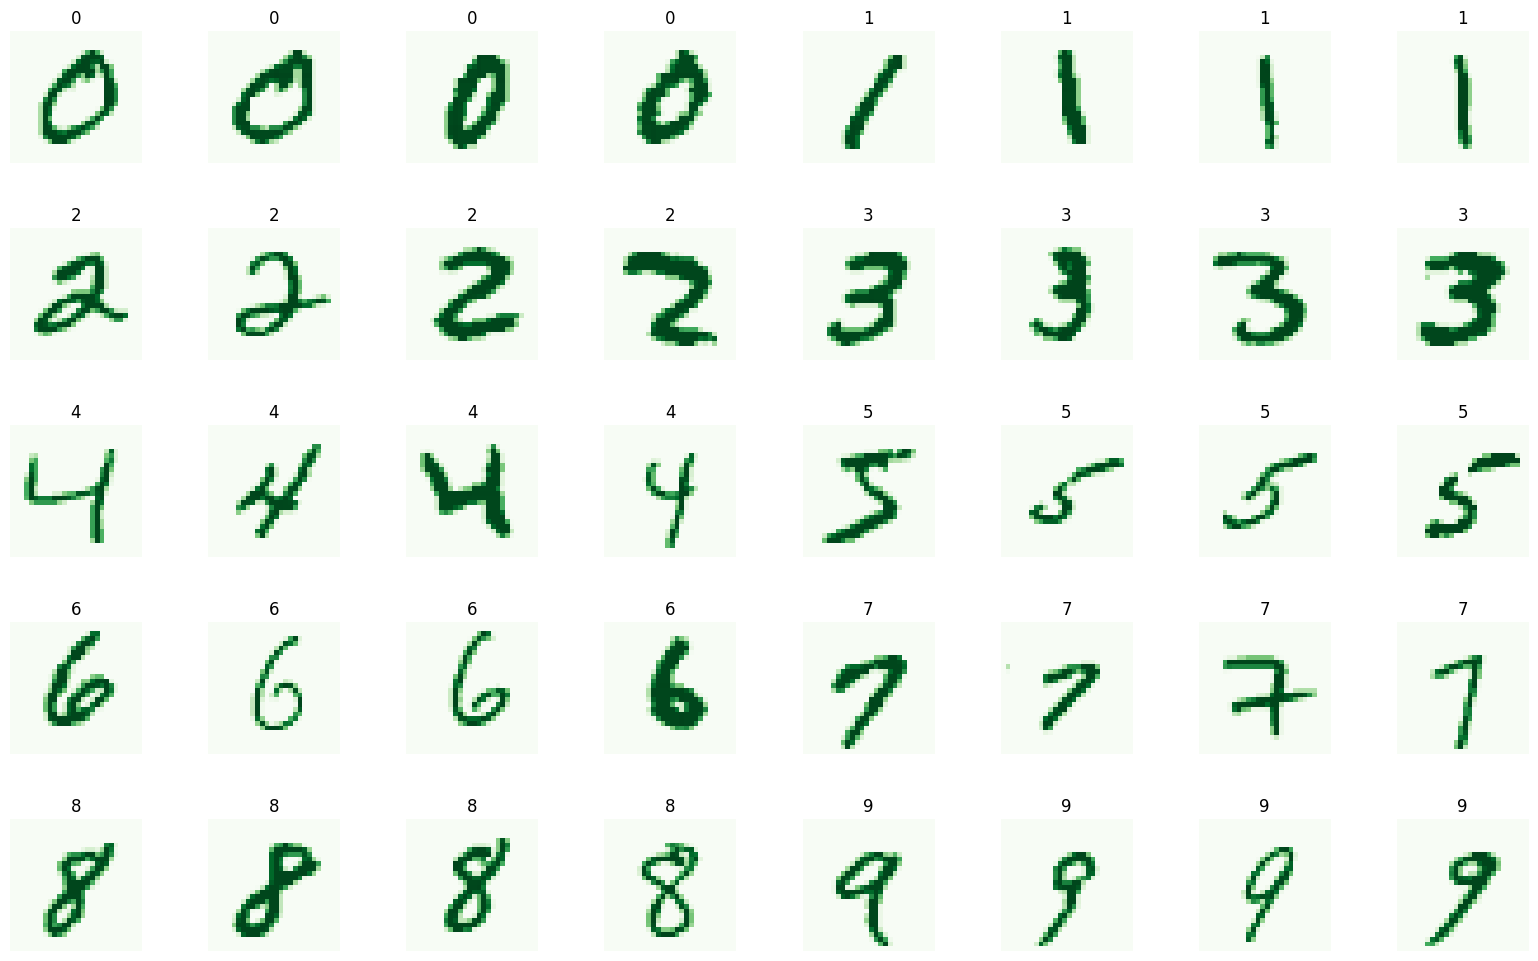

In [ ]:
# Coletar amostras de imagens
train_sample_images, train_sample_labels = sample_images_data(X_train, Y_train)

# Plotar as imagens coletadas
plot_sample_images(train_sample_images, train_sample_labels, cmap="Greens")

### Configurar o Data Augmentation

In [ ]:
# Configurar o data augmentation para
datagen = ImageDataGenerator(
    rotation_range=10,          # Rotação em até 10 graus
    width_shift_range=0.1,      # Translação horizontal em até 10% da largura
    height_shift_range=0.1,     # Translação vertical em até 10% da altura
    zoom_range=0.1,             # Zoom aleatório em até 10%
)

# Ajustar os dados de treinamento
datagen.fit(X_train)

print("Data Augmentation configurado com sucesso!")

Data Augmentation configurado com sucesso!


<ipython-input-13-b1b2a6936d80>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


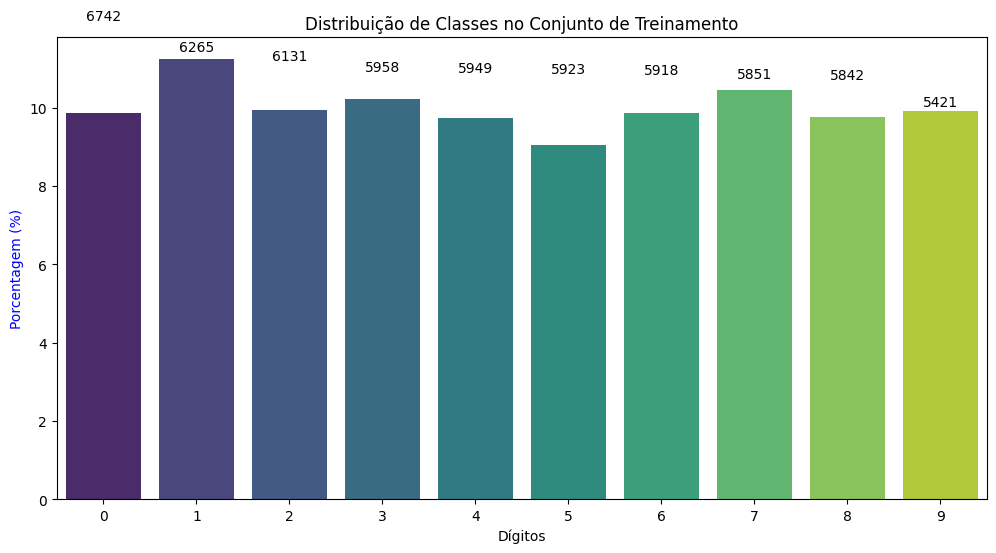

Distribuição de classes (em porcentagem e quantidade):
   Quantidade  Porcentagem (%)
1        6742        11.236667
7        6265        10.441667
3        6131        10.218333
2        5958         9.930000
9        5949         9.915000
0        5923         9.871667
6        5918         9.863333
8        5851         9.751667
4        5842         9.736667
5        5421         9.035000


In [ ]:
# Calcular a distribuição de porcentagens e quantidades
class_counts = np.argmax(Y_train, axis=1)
class_distribution_percent = pd.Series(class_counts).value_counts(normalize=True) * 100
class_distribution_count = pd.Series(class_counts).value_counts()

# Criar o gráfico combinando porcentagens e quantidades
fig, ax1 = plt.subplots(figsize=(12, 6))

# Barras de porcentagem
sns.barplot(
    x=class_distribution_percent.index,
    y=class_distribution_percent.values,
    palette="viridis",
    ax=ax1
)
ax1.set_ylabel("Porcentagem (%)", color="blue")
ax1.set_xlabel("Dígitos")
ax1.set_title("Distribuição de Classes no Conjunto de Treinamento")

# Adicionar rótulos de quantidade acima das barras
for i, value in enumerate(class_distribution_count.values):
    ax1.text(i, class_distribution_percent.values[i] + 1, f"{value}", ha="center", color="black")

plt.show()

# Exibir valores tabulares
print("Distribuição de classes (em porcentagem e quantidade):")
distribution_df = pd.DataFrame({
    "Quantidade": class_distribution_count,
    "Porcentagem (%)": class_distribution_percent
})
print(distribution_df)

## Divisão do Conjunto de Validação

In [ ]:
# Dividir os dados de treinamento em treino e validação
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

# Exibir os novos formatos
print(f"Formato de x_train: {X_train.shape}")
print(f"Formato de x_val: {X_val.shape}")
print(f"Formato de y_train: {Y_train.shape}")
print(f"Formato de y_val: {Y_val.shape}")

Formato de x_train: (48000, 28, 28, 1)
Formato de x_val: (12000, 28, 28, 1)
Formato de y_train: (48000, 10)
Formato de y_val: (12000, 10)


> Uma medida de desempenho em dados que o modelo não viu diretamente durante o treinamento.

> Avaliar a capacidade do modelo de generalizar.

## Modelo

> Para contruir nosso modelo  utilizaremos um modelo sequencial para implementar nossa rede neural convolucional (CNN).

> Um modelo sequencial é uma pilha linear de camadas, onde cada camada é adicionada sequencialmente.



1. Camada Conv2D - camada convolucional bidimensional para capturar padrões espaciais em imagens. Como parâmetros para ela vamos usar:
*   **filters**: Número de filtros (kernels) utilizados na camada; neste caso, 32.
*   **kernel_size**: Dimensão do kernel, definida como (3x3).
*   **activation**: Função de ativação utilizada; aqui, utilizamos ReLU.
* **kernel_initializer**: Método para inicialização dos pesos do kernel.
* **input_shape**: Dimensão da entrada; no nosso caso, (28, 28, 1) (imagens em tons de cinza).
---
2. Camada MaxPooling2D - operação de pooling **máximo** em dados espaciais, usada para reduzir as dimensões das features extraídas e controlar overfitting. Os parâmetros utilizados são:
* **pool_size**: Fatores de downscaling para cada direção; aqui, definimos (2, 2).
---
3. Camada Dropout - técnica para evitar overfitting, desativando aleatoriamente neurônios de entrada durante o treinamento. O parâmetro configurado é:
* **rate**: Taxa de dropout em 0.25.
---
4. Adicionando mais Camadas Convolucionais -
Repetimos o padrão de camadas convolucionais e pooling, aumentando progressivamente o número de filtros e ajustando o dropout para lidar com a complexidade crescente, nessa caso vamos adicionar mais duas camadas:
* **Segunda camada**
  >Conv2D: 64 filtros, kernel de (3x3), ativação ReLU.

  >MaxPooling2D: Pool de (2x2).

  >Dropout: Taxa de 0.25.

* **Terceira  camada**
  >Conv2D: 128 filtros, kernel de (3x3), ativação ReLU.

  >Dropout: Taxa de 0.4.
---
5. Camada Flatten - Esta camada achata a entrada 3D para 1D, preparando-a para as camadas densas. Não possui parâmetros configuráveis.
---
6. Camada Dense (Totalmente Conectada) -
Uma camada densa (MLP) regular conecta cada unidade da entrada a cada unidade da saída. Configuramos duas dessas camadas:
* **Primeira camada**
  >units/neurônios: 128 (dimensionalidade do espaço de saída).

  >activation: ReLU.

  >Dropout: Taxa de 0.3.

* **Segunda camada (camada de saída):**
  >units/neurônios: Número de classes (no nosso caso, 10).

  >activation: Softmax, usado para classificação multiclasse.
---
7. Compilação do Modelo - Compilamos o modelo especificando os seguintes parâmetros:
* **loss**: Função de perda, aqui usamos categorical_crossentropy, adequada para problemas de classificação multiclasse com rótulos codificados em one-hot.
* **optimizer**: Optimizador do modelo; utilizaremos Adam.
* **metrics**: Métrica para avaliar o desempenho durante o treinamento, configurada como accuracy.

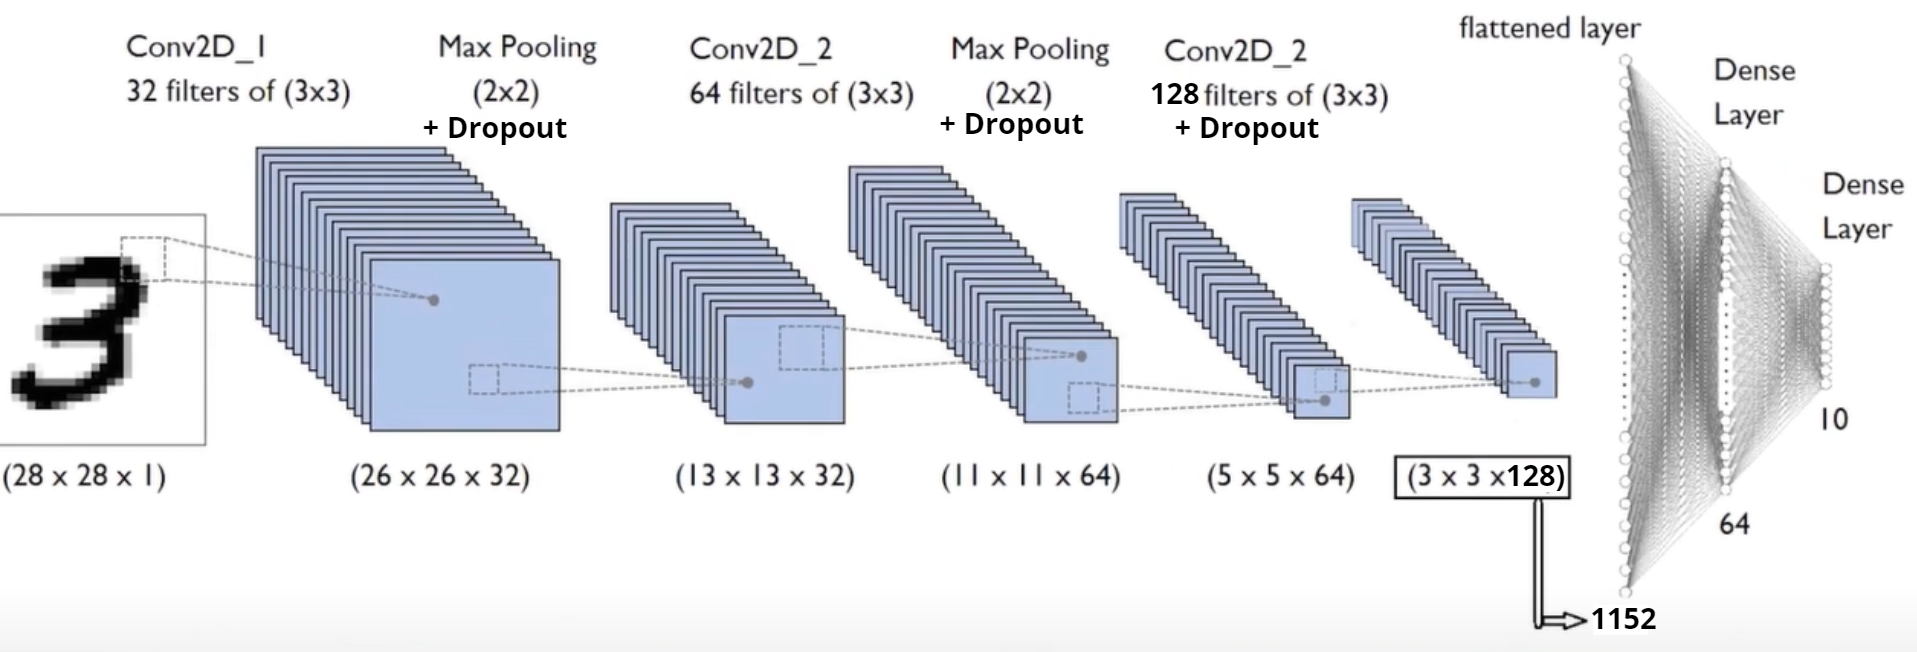

In [ ]:
# Inicializar o modelo sequencial
model = Sequential()

# Primeira camada convolucional e pooling
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Segunda camada convolucional e pooling
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Terceira camada convolucional
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.4))

# Achatar as dimensões
model.add(Flatten())

# Primeira camada densa (fully connected)
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.3))

# Camada de saída (softmax)
model.add(Dense(units=10, activation='softmax'))

# Compilar o modelo
model.compile(
    optimizer='adam',  # Otimizador Adam
    loss='categorical_crossentropy',  # Função de perda para classificação multiclasse
    metrics=['accuracy']  # Métrica para monitorar
)

# Exibir o resumo da arquitetura
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

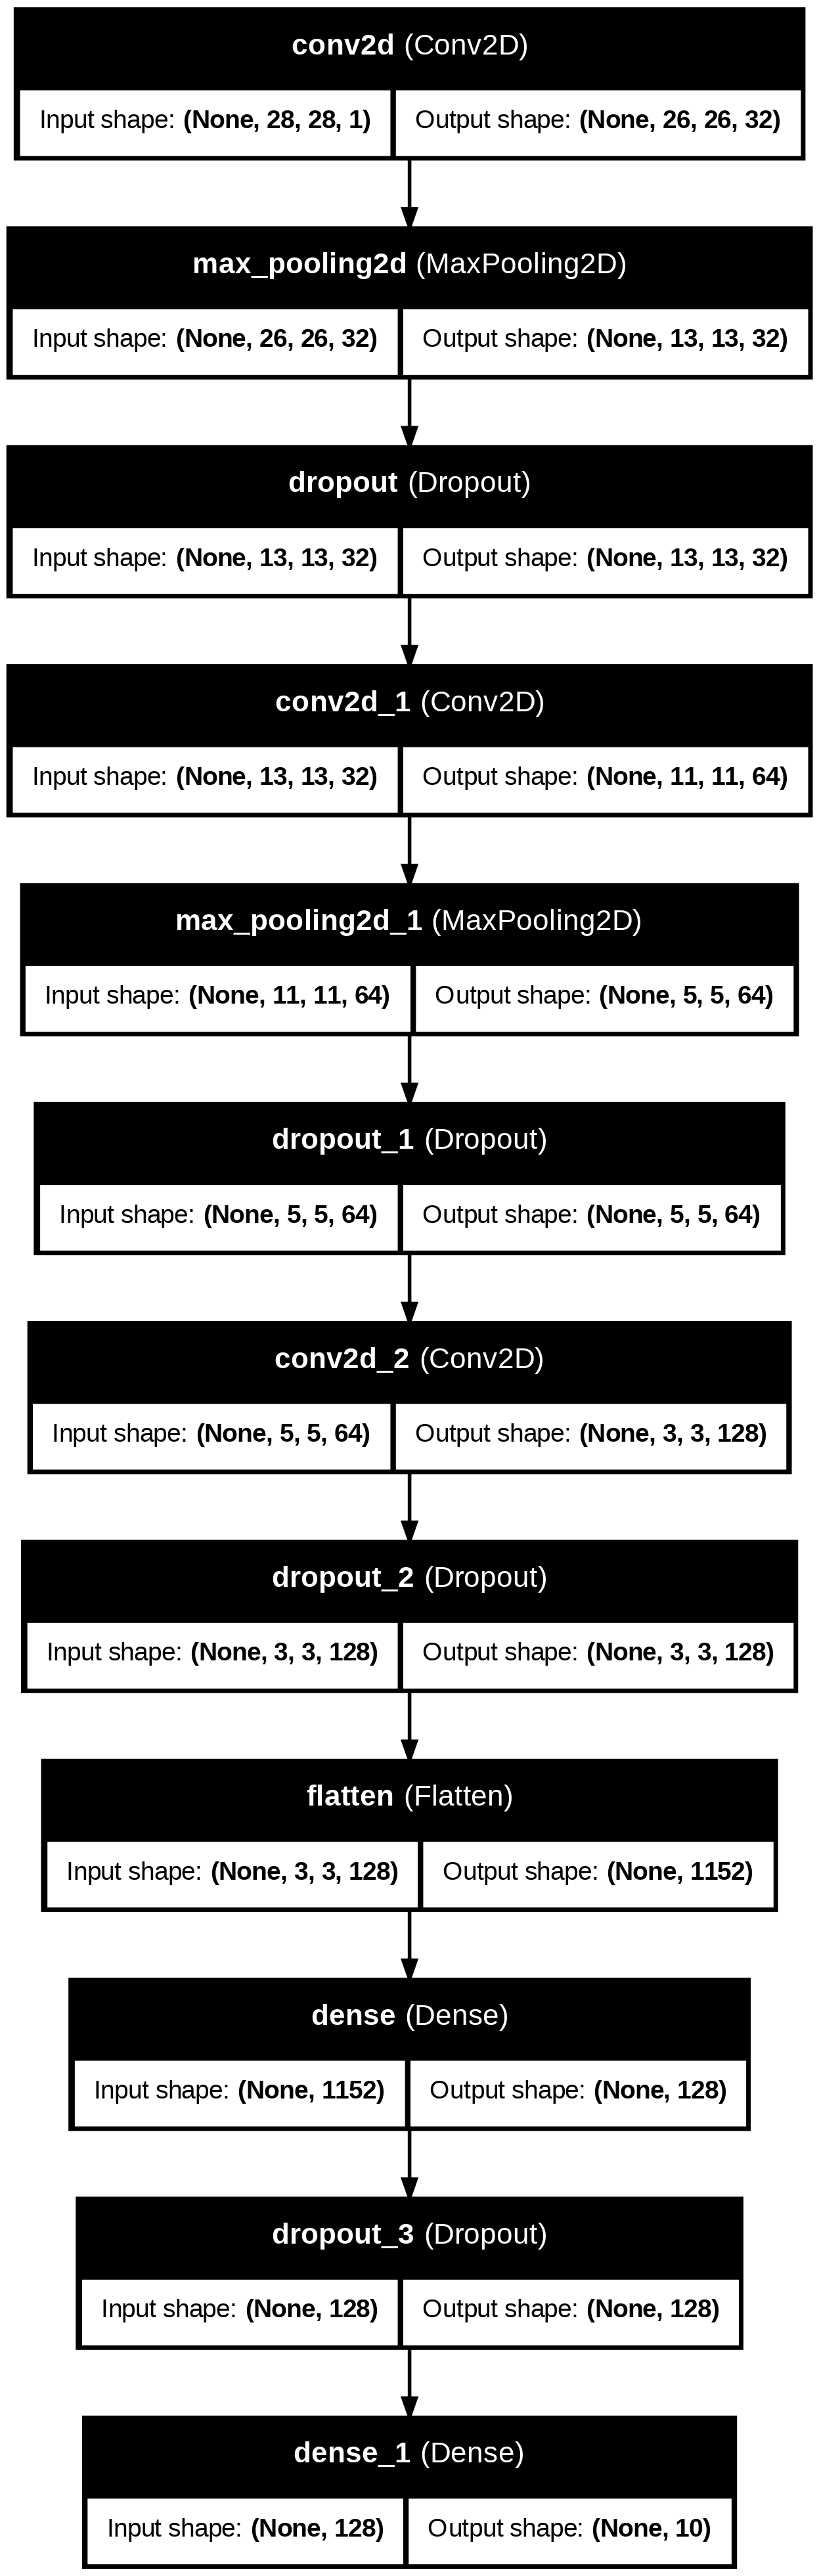

In [ ]:
# Plotar o modelo e salvar em um arquivo
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Renderizar o diagrama diretamente no notebook em formato SVG
#SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

## Treinamento

In [ ]:
# Configurar hiperparâmetros
PATIENCE = 5  # Número de épocas sem melhora antes de parar
VERBOSE = 1   # Exibir mensagens detalhadas
BATCH_SIZE = 64  # Tamanho do batch
NO_EPOCHS = 50   # Número máximo de épocas

# Configurar callbacks
earlystopper = EarlyStopping(
    monitor='loss',       # Monitorar a perda do modelo
    patience=PATIENCE,    # Parar após PATIENCE épocas sem melhora
    verbose=VERBOSE
)
checkpointer = ModelCheckpoint(
    'best_model.weights.h5',      # Nome do arquivo onde o melhor modelo será salvo
    monitor='val_accuracy',  # Monitorar a métrica de validação
    verbose=VERBOSE,
    save_best_only=True,  # Salvar apenas o melhor modelo
    save_weights_only=True  # Salvar apenas os pesos
)

# Treinar o modelo
history = model.fit(
    X_train, Y_train,
    batch_size=BATCH_SIZE,
    epochs=NO_EPOCHS,
    verbose=VERBOSE,
    validation_data=(X_val, Y_val),  # Dados de validação
    callbacks=[earlystopper, checkpointer]  # Callbacks configurados
)

Epoch 1/50
733/750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7976 - loss: 0.6166
Epoch 1: val_accuracy improved from -inf to 0.97942, saving model to best_model.weights.h5
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8003 - loss: 0.6088 - val_accuracy: 0.9794 - val_loss: 0.0639
Epoch 2/50
746/750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9684 - loss: 0.1008
Epoch 2: val_accuracy improved from 0.97942 to 0.98758, saving model to best_model.weights.h5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9684 - loss: 0.1008 - val_accuracy: 0.9876 - val_loss: 0.0423
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9788 - loss: 0.0708
Epoch 3: val_accuracy improved from 0.98758 to 0.98783, saving model to best_model.weights.h5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9788 - loss: 0.0708 - val_accuracy: 0.9878 - val_loss: 0.0394
Epoch 4/50
732/750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9810 - loss: 0.0613
Epoch 4: val_accuracy imp

## Validação Acc e Loss

> Plot a acc do conjunto de validação em comparação com a acc do conjunto de treinamento, para cada época, no mesmo gráfico.

> Plot da loss do conjunto de validação em comparação com a loss do conjunto de treinamento.

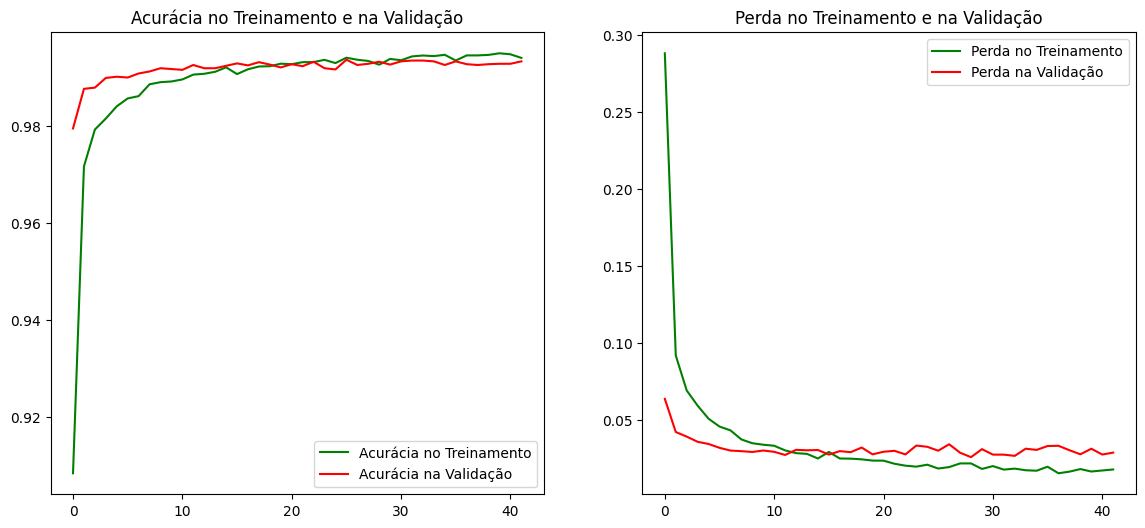

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(train_model):
    hist = train_model.history  # Histórico do treinamento
    acc = hist['accuracy']  # Acurácia do treinamento
    val_acc = hist['val_accuracy']  # Acurácia da validação
    loss = hist['loss']  # Perda do treinamento
    val_loss = hist['val_loss']  # Perda da validação
    epochs = range(len(acc))  # Número de épocas

    # Criar subplots para acurácia e perda
    f, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Acurácia
    ax[0].plot(epochs, acc, 'g', label='Acc no Treinamento')
    ax[0].plot(epochs, val_acc, 'r', label='Acc na Validação')
    ax[0].set_title('Acc no Treinamento e na Validação')
    ax[0].legend()

    # Perda
    ax[1].plot(epochs, loss, 'g', label='Loss no Treinamento')
    ax[1].plot(epochs, val_loss, 'r', label='Loss na Validação')
    ax[1].set_title('Loss no Treinamento e na Validação')
    ax[1].legend()

    plt.show()

plot_accuracy_and_loss(history)

## Validação Acc/classe

In [ ]:
# Fazer previsões no conjunto de validação
Y_pred = model.predict(X_val)

# Converter as previsões de one-hot encoding para rótulos de classe
y_pred_classes = np.argmax(Y_pred, axis=1)

# Converter os rótulos reais de one-hot encoding para rótulos de classe
y_true_classes = np.argmax(Y_val, axis=1)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
# Gerar relatório de classificação
report = classification_report(y_true_classes, y_pred_classes, target_names=[str(i) for i in range(10)])
print("Relatório de Classificação:\n")
print(report)

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1175
           1       1.00      1.00      1.00      1322
           2       0.99      0.99      0.99      1174
           3       1.00      0.99      0.99      1219
           4       0.99      0.99      0.99      1176
           5       0.99      0.99      0.99      1104
           6       0.99      1.00      1.00      1177
           7       0.99      0.99      0.99      1299
           8       0.99      0.99      0.99      1160
           9       0.99      0.99      0.99      1194

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000



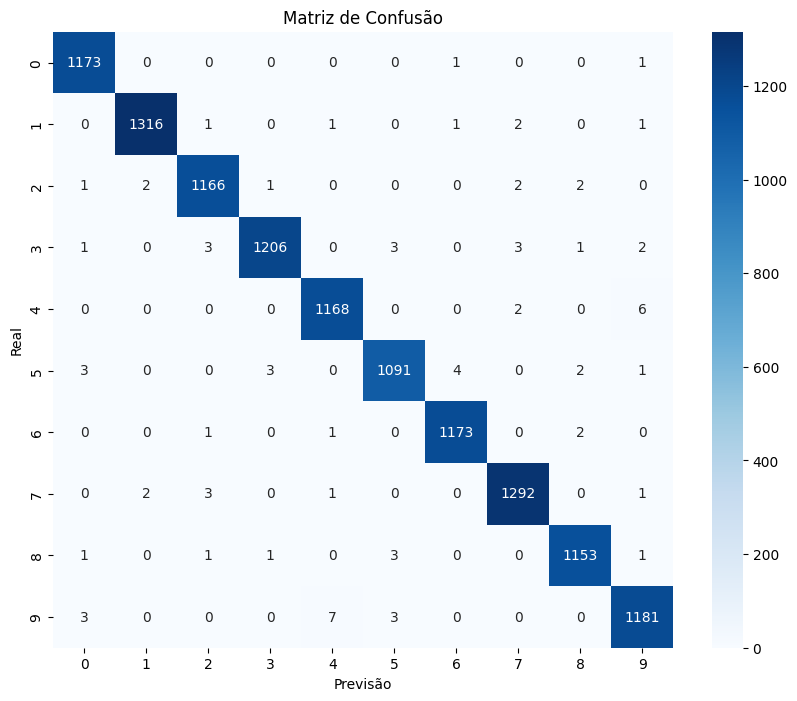

In [ ]:
# Gerar matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plotar matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title("Matriz de Confusão")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()

In [ ]:
# Calcular a precisão para cada classe
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Exibir a precisão por classe
for i, accuracy in enumerate(class_accuracy):
    print(f"Classe {i}: {accuracy:.2%} de acurácia")

Classe 0: 99.83% de acurácia
Classe 1: 99.55% de acurácia
Classe 2: 99.32% de acurácia
Classe 3: 98.93% de acurácia
Classe 4: 99.32% de acurácia
Classe 5: 98.82% de acurácia
Classe 6: 99.66% de acurácia
Classe 7: 99.46% de acurácia
Classe 8: 99.40% de acurácia
Classe 9: 98.91% de acurácia


## Visualização 2

In [ ]:
# Índices de previsões corretas e incorretas
correct = np.where(y_true_classes == y_pred_classes)[0]
incorrect = np.where(y_true_classes != y_pred_classes)[0]

In [ ]:
# Função para plot dos acertos e erros
def plot_images(data_index, x_data, y_true, y_pred, cmap="Blues"):
    # Configurar o subplot
    f, ax = plt.subplots(4, 4, figsize=(12, 12))
    for i, indx in enumerate(data_index[:16]):  # Plotar até 16 imagens
        ax[i // 4, i % 4].imshow(x_data[indx].reshape(28, 28), cmap=cmap)
        ax[i // 4, i % 4].axis('off')
        ax[i // 4, i % 4].set_title(f"True: {y_true[indx]} | Pred: {y_pred[indx]}")
    plt.show()

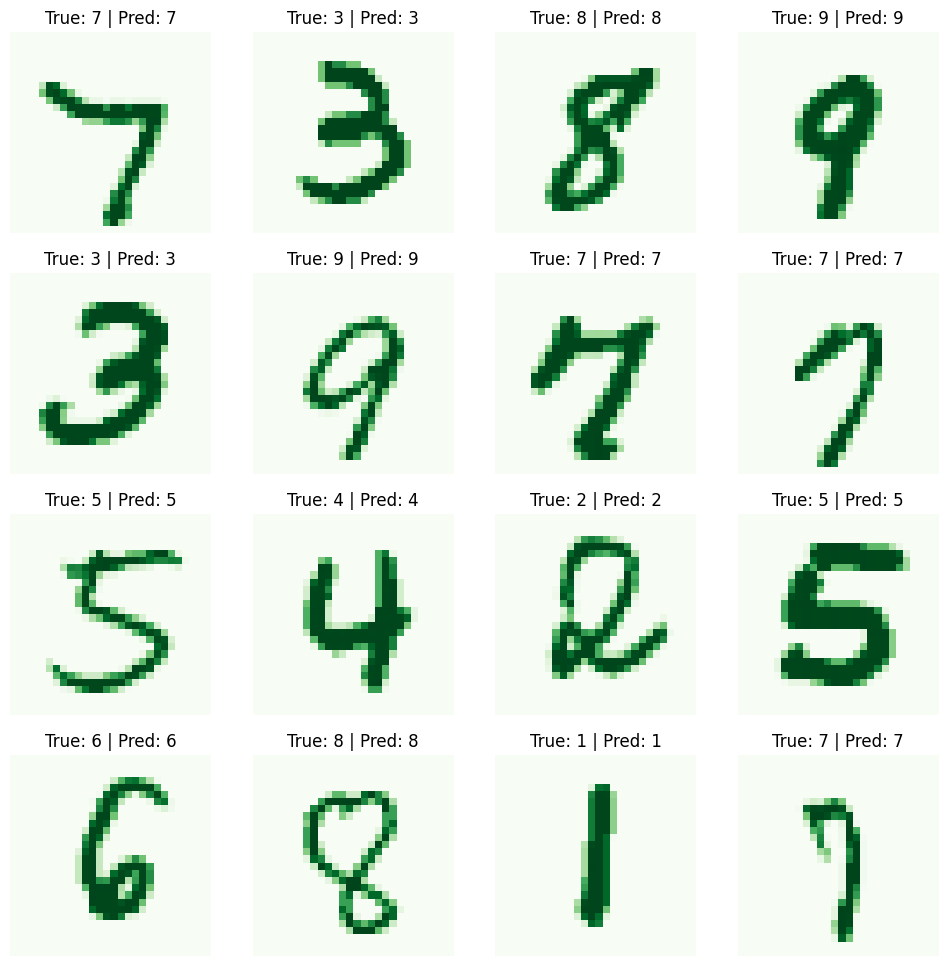

In [ ]:
# Plotar exemplos de previsões corretas
plot_images(correct, X_val, y_true_classes, y_pred_classes, cmap="Greens")

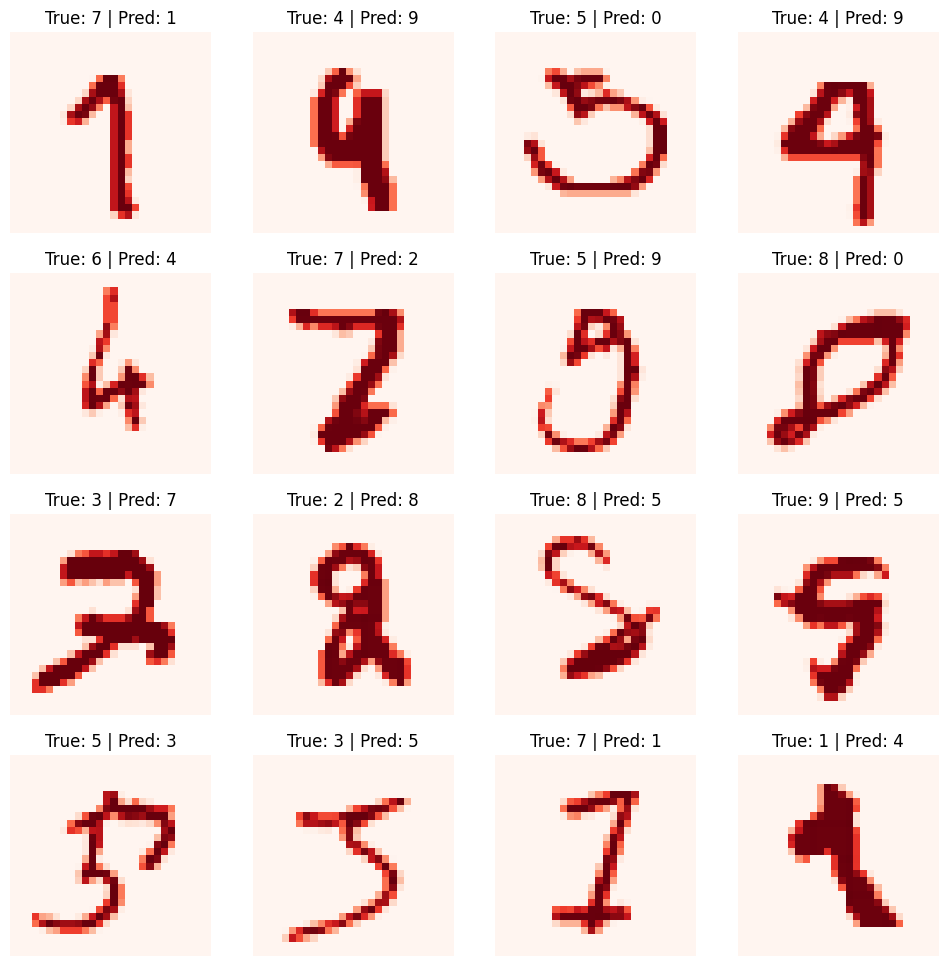

In [ ]:
# Plotar exemplos de previsões incorretas
plot_images(incorrect, X_val, y_true_classes, y_pred_classes, cmap="Reds")